### Problem Statement

Build a recommendation system (collaborative) for an online beer store, where customers will be recommended the beer that they are most likely to buy.

In [89]:
# Supress warnings
import warnings
warnings.filterwarnings('ignore')

In [90]:
# Import all required packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from numpy import *
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances

In [91]:
# Read ratings file
df_beer = pd.read_csv('beer_data.csv')

In [92]:
df_beer.head()

,beer_beerid,review_profilename,review_overall
0,48215,stcules,3.0
1,52159,oline73,3.0
2,52159,alpinebryant,3.0
3,52159,rawthar,4.0
4,52159,RangerClegg,3.5


In [93]:
# Dataframe dimension
df_beer.shape

(475984, 3)

In [94]:
df_beer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 475984 entries, 0 to 475983
Data columns (total 3 columns):
beer_beerid           475984 non-null int64
review_profilename    475884 non-null object
review_overall        475984 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 10.9+ MB


In [95]:
df_beer.describe()

,beer_beerid,review_overall
count,475984.000000,475984.000000
mean,21660.550611,3.814827
std,21793.437326,0.720411
min,3.000000,0.000000
25%,1716.000000,3.500000
50%,13892.000000,4.000000
75%,39397.000000,4.500000
max,77317.000000,5.000000


### Data Preparation

#### 1. Remove Duplicate Rows

In [96]:
# Check if there are duplicate rows in the dataset
sum(df_beer.duplicated(subset = ['beer_beerid', 'review_profilename']))

1424

There are **1424** duplicate rows in the dataset. Let's remove the duplicate rows.

In [97]:
# Duplicate rows
df_beer[df_beer.duplicated(subset = ['beer_beerid', 'review_profilename'])].head()

,beer_beerid,review_profilename,review_overall
1248,52211,AleWatcher,3.5
2301,73647,barleywinefiend,4.5
2349,14243,northyorksammy,2.5
2608,1122,Slatetank,4.0
2874,1121,kenito799,4.5


In [98]:
# Drop duplicate rows
df_beer.drop_duplicates(subset = ['beer_beerid', 'review_profilename'], 
                        keep = 'first', inplace = True)

In [99]:
# Again check for duplicate rows
sum(df_beer.duplicated(subset = ['beer_beerid', 'review_profilename']))

0

Now, there are NO duplicate rows in the dataset.

#### 2. Handle Missing Values

In [100]:
# Check for NaN values in dataset
print(df_beer.isnull().values.any())
print(df_beer.isnull().values.sum())

True
98


There are **98** NaN values in the dataset.

In [101]:
# Check NaN values
df_beer[df_beer.isnull().values]

,beer_beerid,review_profilename,review_overall
2700,29687,NaN,4.0
9545,5441,NaN,4.0
12252,1504,NaN,4.5
25270,1904,NaN,4.5
33728,2130,NaN,2.5
33814,14941,NaN,3.5
34077,2131,NaN,4.0
38544,3967,NaN,2.0
40389,31323,NaN,3.5
49380,3158,NaN,3.5


- There are two options either to impute these NaN values or drop such rows.
- Since all these NaN values are for 'review_profilename', if we impute them then it would mean that a new <br>profilename with name '0' has rated some of the some of the beers, which does not looks correct. <br>
Because we are not sure if all these NaN 'review_profilename' are by the same person.
- Also, in this huge dataset only 98 rows are with NaN values, so deleting them won't make much difference.
- So, let's delete such rows.

In [102]:
# Drop rows with missing values
df_beer.dropna(inplace=True)

In [103]:
# Check if the missing values are dropped
print(df_beer.isnull().values.any())
print(df_beer.isnull().values.sum())

False
0


Now, the dataset does not contain any missing values.

#### 3. Find N (Number of Ratings)

In [104]:
df_beer['beer_beerid'].value_counts()

2093     977
412      966
1904     902
1093     840
92       812
4083     798
276      788
7971     778
88       755
1013     750
34       743
17112    741
11757    721
2671     712
695      704
6108     703
1005     703
680      702
754      690
1160     685
104      684
1708     681
645      678
355      674
131      655
73       651
571      616
30420    612
2512     603
731      588
        ... 
37242      1
45438      1
47487      1
66120      1
76365      1
17122      1
27237      1
23265      1
72011      1
39035      1
44914      1
63607      1
38773      1
65400      1
61306      1
59259      1
57212      1
55165      1
13036      1
73804      1
746        1
22627      1
30823      1
25318      1
6251       1
31461      1
53362      1
57460      1
42666      1
69794      1
Name: beer_beerid, Length: 40304, dtype: int64

Observations:
- N (number of reviews) ranges between 1 and 977.
- We should not choose beers that have an extremely low number of ratings.

Let's perform some EDA to get the appropriate value of N.<br>
We can begin with plotting univariate distribution.

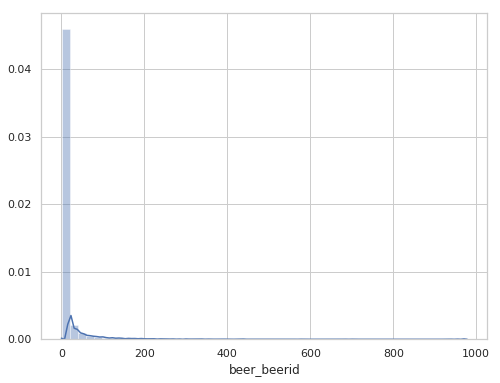

In [105]:
# Univariate Distribution
plt.figure(figsize = (8,6))
sns.distplot(df_beer['beer_beerid'].value_counts())

- Above chart shows a large number of beers have an extremely low number of ratings.
- Let's try Boxplot.

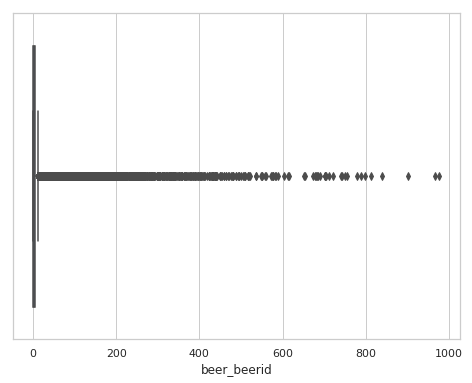

In [106]:
# Plot Boxplot
plt.figure(figsize = (8,6))
sns.set(style='whitegrid')
ax = sns.boxplot(x=df_beer['beer_beerid'].value_counts())

- The above boxplot shows that a large number of beers have very small number of reviews.
- Let's plot this chart in different way to get a better picture.

In [107]:
# Check for the value of N in different quantile range
quantile = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.7, 0.8, 0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 1]
quant_output = []

for q in quantile:
    qu = df_beer['beer_beerid'].value_counts().quantile(q)
    print('%-4s : %s' % (q, qu))
    quant_output.append(qu)

0.1  : 1.0
0.2  : 1.0
0.3  : 1.0
0.4  : 1.0
0.5  : 2.0
0.6  : 2.0
0.7  : 4.0
0.7  : 4.0
0.8  : 7.0
0.9  : 21.0
0.91 : 24.0
0.92 : 28.0
0.93 : 34.0
0.94 : 41.0
0.95 : 51.0
0.96 : 65.0
0.97 : 86.0
0.98 : 121.0
0.99 : 195.0
1    : 977.0


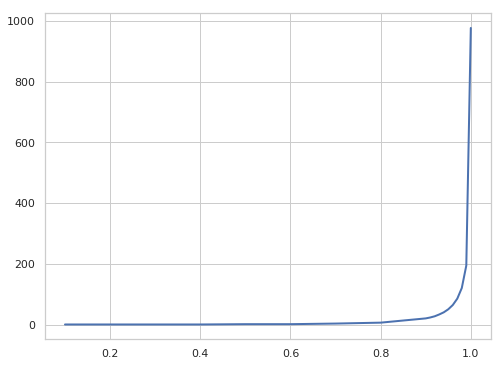

In [108]:
# Plot N vs. Quantile Range
plt.figure(figsize = (8,6))
plt.plot(quantile, quant_output, linewidth = 2.0)

Observation:
- Value of N increases exponentiatlly towards the end i.e. quantile value of 1.
- Upto 95 percentile number of ratings are very low.

So, let's select only those rows which have N value more than 95 percentile i.e. **N >= 51**.

In [109]:
vc = df_beer['beer_beerid'].value_counts().quantile(0.95)
vc

51.0

In [110]:
df_beer.shape

(474462, 3)

In [111]:
vc = df_beer['beer_beerid'].value_counts()

quant_95 = df_beer['beer_beerid'].value_counts().quantile(0.95)

beers_with_more_ratings = (vc >= quant_95)[(vc >= quant_95).values == True].index

beers_with_more_ratings

Int64Index([ 2093,   412,  1904,  1093,    92,  4083,   276,  7971,    88,
             1013,
            ...
              320, 49279, 30679,   771, 14687, 53202, 60886,   876,  8789,
             2709],
           dtype='int64', length=2028)

In [112]:
# Filter out the rows with less than 95 percentile of beer ratings N<51.
df_beer = df_beer.loc[df_beer['beer_beerid'].isin(beers_with_more_ratings)]

In [113]:
df_beer.shape

(294197, 3)

Now, after filtering out rows with N < 51, our dataset has **294197** rows remaining.

### Data exploration

#### 1. What are the unique values of ratings?

In [114]:
print(len(df_beer['review_overall'].unique()))
df_beer['review_overall'].unique()

9


array([3. , 4.5, 4. , 5. , 3.5, 2. , 2.5, 1.5, 1. ])

Let's plot these values.

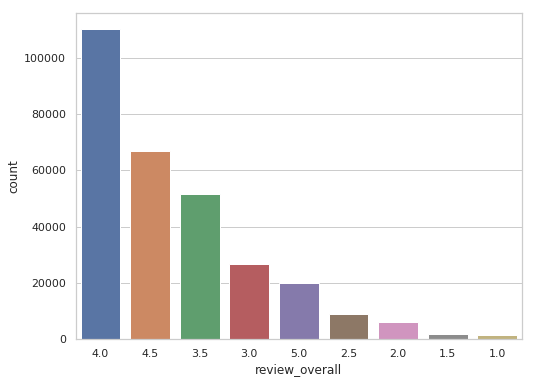

In [115]:
# Count Plot
plt.figure(figsize = (8,6))
sns.countplot(x = 'review_overall', data=df_beer, order = df_beer['review_overall'].value_counts().index)

- **4** rating is the most provided rating.
- Very few beers have rating **1**.

#### 2. Visualise the rating values and notice:

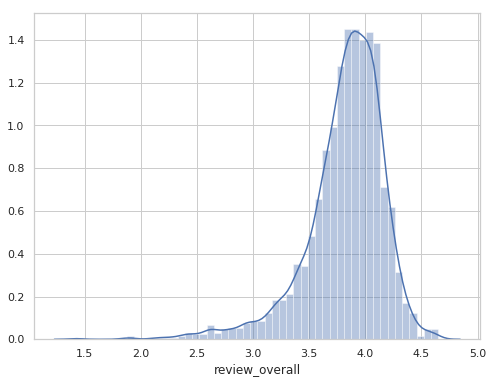

In [116]:
# 1. The average beer ratings

avg_beer_ratings = df_beer.groupby(['beer_beerid'])['review_overall'].mean()

plt.figure(figsize = (8,6))
sns.distplot(avg_beer_ratings)

In [117]:
avg_beer_ratings.describe()

count    2028.000000
mean        3.820188
std         0.350447
min         1.425676
25%         3.670910
50%         3.875000
75%         4.049564
max         4.650735
Name: review_overall, dtype: float64

Average beer rating (Mean) is 3.820188.

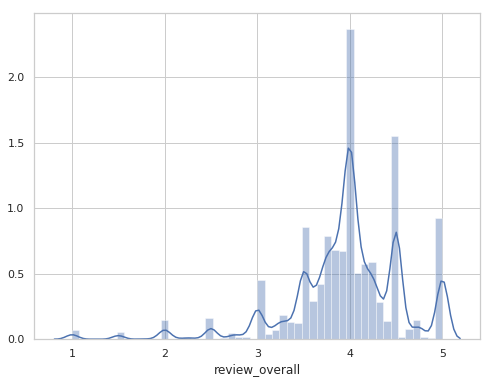

In [118]:
# 2. The average user ratings

avg_user_ratings = df_beer.groupby(['review_profilename'])['review_overall'].mean()

plt.figure(figsize = (8,6))
sns.distplot(avg_user_ratings)

In [119]:
avg_user_ratings.describe()

count    19447.000000
mean         3.950609
std          0.621541
min          1.000000
25%          3.714286
50%          4.000000
75%          4.300000
max          5.000000
Name: review_overall, dtype: float64

Average beer rating (Mean) is 3.950609.

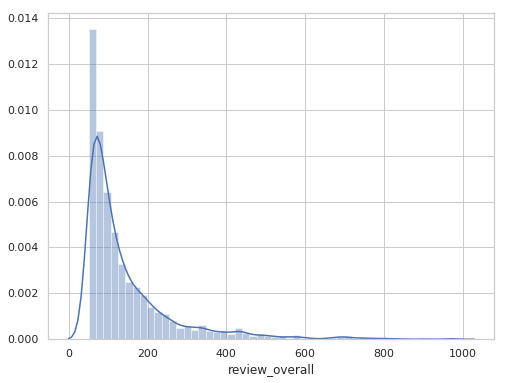

In [120]:
# 3. The average number of ratings given to the beers

avg_num_beer_ratings = df_beer.groupby(['beer_beerid'])['review_overall'].count()

plt.figure(figsize = (8,6))
sns.distplot(avg_num_beer_ratings)

In [121]:
avg_num_beer_ratings.describe()

count    2028.000000
mean      145.067554
std       122.624804
min        51.000000
25%        69.000000
50%       100.000000
75%       170.000000
max       977.000000
Name: review_overall, dtype: float64

Mean = 145.067554, which means on average each beer gets around 145 reviews.

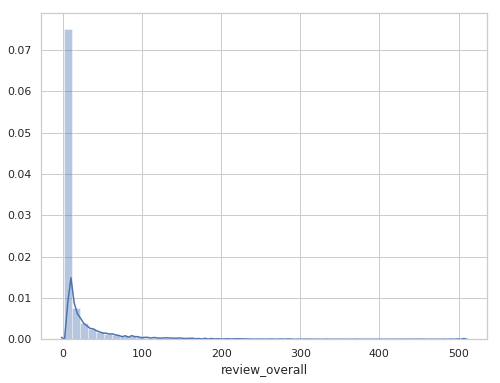

In [122]:
# 4. The average number of ratings given by the users

avg_num_user_ratings = df_beer.groupby(['review_profilename'])['review_overall'].count()

plt.figure(figsize = (8,6))
sns.distplot(avg_num_user_ratings)

In [123]:
avg_num_user_ratings.describe()

count    19447.000000
mean        15.128143
std         36.208335
min          1.000000
25%          1.000000
50%          3.000000
75%         10.000000
max        508.000000
Name: review_overall, dtype: float64

Mean = 15.128143, which means on average each user gives around 15 reviews.

### Recommendation Models

#### 3.1. Divide data into training and testing dataset.

In [124]:
# Split into train and test data
train, test = train_test_split(df_beer, test_size = 0.30, random_state = 31)

In [125]:
# Check for size of train and test data
print(train.shape)
print(test.shape)

(205937, 3)
(88260, 3)


#### 3.2. Build user-based and item-based models.

In [126]:
# User based model
df_user_model = train.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

In [127]:
df_user_model.head(30)

beer_beerid,5,6,7,10,14,15,17,19,30,31,33,34,36,39,54,55,58,59,61,63,65,67,69,73,74,78,79,80,81,82,83,85,86,87,88,89,90,92,93,96,...,65200,65325,65862,66036,66037,66281,66436,67040,67044,67106,67156,67219,67230,67262,67267,68008,68400,68746,68772,68916,68958,68960,69070,69363,69407,70102,70910,71405,71758,71774,71919,71969,72138,73131,74123,74272,74323,74390,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0110x011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01Ryan10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04101Brewer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
05Harley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0beerguy0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0runkp0s,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0tt0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000Bottles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100floods,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
# Item based model
df_item_model = train.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).T

In [129]:
df_item_model.head(30)

review_profilename,0110x011,01Ryan10,04101Brewer,05Harley,0beerguy0,0runkp0s,0tt0,1000Bottles,100floods,1050Sudz,108Dragons,1099,1121987,11millsown113,11osixBrew,11thFloorBrewing,12ouncecurls,12vUnion,13aphomet,13smurrf,160Shillings,1759Girl,18alpha,1Adam12,1after909,1fastz28,1inamill,1morebeer,1noa,1quiks10,1santore,1whiskey,20ozmonkey,21mmer,220emaple,2378GCGTG,23fyerfyter,24Beer92,28Rock,2BDChicago,...,zfjohnson,zhanson88,zhooker,zic,ziggy13,zimm421,zimmerbloke,zipperergj,zjungleist,zloew,zminor,zms101,znarf,znichols,zodiacv1,zodiak3000,zooalbert,zooga,zook74,zoolzoo,zornbeast,zoso1967,zoso493,zplug123,zrab11,zseeanz,zsk,ztaylor1,ztprez,zuccard,zuffenhausen,zuggy9,zulufactor,zwalk8,zymrgy,zymurgy4all,zymurgywhiz,zythus,zyzygy,zzajjber
beer_beerid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Before moving to next question let's create dummy_train and dummy_test which will be used later.

#### Create dummy_train and dummy_test

In [130]:
# Create dummy_train and dummy_test
dummy_train = train.copy()
dummy_test = test.copy()

In [131]:
# Fill relevant values
dummy_train['review_overall'] = dummy_train['review_overall'].apply(lambda x: 0 if x>=1 else 1)
dummy_test['review_overall'] = dummy_test['review_overall'].apply(lambda x: 1 if x>=1 else 0)

In [132]:
# The beers not rated by reviewer is marked as 1 for prediction. 
dummy_train = dummy_train.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).fillna(1)

# The beers not rated by reviewer is marked as 0 for evaluation. 
dummy_test = dummy_test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).fillna(0)

In [133]:
dummy_train.head(30)

beer_beerid,5,6,7,10,14,15,17,19,30,31,33,34,36,39,54,55,58,59,61,63,65,67,69,73,74,78,79,80,81,82,83,85,86,87,88,89,90,92,93,96,...,65200,65325,65862,66036,66037,66281,66436,67040,67044,67106,67156,67219,67230,67262,67267,68008,68400,68746,68772,68916,68958,68960,69070,69363,69407,70102,70910,71405,71758,71774,71919,71969,72138,73131,74123,74272,74323,74390,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0110x011,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
01Ryan10,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
04101Brewer,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
05Harley,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0beerguy0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0runkp0s,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
0tt0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1000Bottles,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
100floods,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [134]:
dummy_test.head(30)

beer_beerid,5,6,7,10,14,15,17,19,30,31,33,34,36,39,54,55,58,59,61,63,65,67,69,73,74,78,79,80,81,82,83,85,86,87,88,89,90,92,93,96,...,65200,65325,65862,66036,66037,66281,66436,67040,67044,67106,67156,67219,67230,67262,67267,68008,68400,68746,68772,68916,68958,68960,69070,69363,69407,70102,70910,71405,71758,71774,71919,71969,72138,73131,74123,74272,74323,74390,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05Harley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0tt0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100floods,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1121987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11millsown113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11osixBrew,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### 3.3. Determine how similar the first 10 users are to each other and visualise it.

#### Normalising the ratings

In [135]:
mean = np.nanmean(df_user_model, axis=1)
df_subtracted = (df_user_model.T-mean).T

In [136]:
df_subtracted.head(30)

beer_beerid,5,6,7,10,14,15,17,19,30,31,33,34,36,39,54,55,58,59,61,63,65,67,69,73,74,78,79,80,81,82,83,85,86,87,88,89,90,92,93,96,...,65200,65325,65862,66036,66037,66281,66436,67040,67044,67106,67156,67219,67230,67262,67267,68008,68400,68746,68772,68916,68958,68960,69070,69363,69407,70102,70910,71405,71758,71774,71919,71969,72138,73131,74123,74272,74323,74390,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0110x011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
01Ryan10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
04101Brewer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
05Harley,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0beerguy0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0runkp0s,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0tt0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1000Bottles,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100floods,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


##### Finding Cosine Similarity

In [137]:
# User Similarity Matrix
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [138]:
user_correlation[user_correlation<0]=0
user_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [139]:
user_predicted_ratings = np.dot(user_correlation, df_user_model.fillna(0))
user_predicted_ratings

array([[1.18210979, 2.39586718, 2.00712931, ..., 1.30620554, 2.19226756,
        1.58426839],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.56729534, 5.22367115, 2.53076101, ..., 0.44452145, 0.71906464,
        2.19279431],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [140]:
user_predicted_ratings.shape

(17202, 2028)

In [141]:
user_final_rating = np.multiply(user_predicted_ratings, dummy_train)
user_final_rating.head()

beer_beerid,5,6,7,10,14,15,17,19,30,31,33,34,36,39,54,55,58,59,61,63,65,67,69,73,74,78,79,80,81,82,83,85,86,87,88,89,90,92,93,96,...,65200,65325,65862,66036,66037,66281,66436,67040,67044,67106,67156,67219,67230,67262,67267,68008,68400,68746,68772,68916,68958,68960,69070,69363,69407,70102,70910,71405,71758,71774,71919,71969,72138,73131,74123,74272,74323,74390,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0110x011,1.182110,2.395867,2.007129,2.383969,0.117704,1.158166,2.348213,1.834791,5.900556,3.069009,6.320933,11.004264,1.941328,7.726463,0.851823,3.626533,2.460885,5.211831,5.729038,6.421275,2.249000,1.416910,0.452228,7.275238,2.234638,0.608799,1.056725,0.633652,1.720428,0.258660,0.539217,2.916656,1.494359,3.030484,9.209862,2.060899,6.905795,9.358838,1.029690,1.771866,...,1.201429,0.628539,1.731964,1.644536,1.608598,2.199801,2.973070,0.751025,1.431912,1.406231,1.280014,3.704292,0.746748,1.205332,0.922172,1.202831,1.187052,0.739329,1.605611,1.479110,1.543608,1.860918,1.896229,2.089652,1.986690,2.640293,2.868229,1.501765,0.721702,1.666966,0.807601,2.263625,6.130013,0.537544,0.302546,0.470864,1.041869,1.306206,2.192268,1.584268
01Ryan10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
04101Brewer,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
05Harley,1.431752,4.224999,2.486638,5.221106,0.468807,1.552946,4.277244,2.620628,12.121386,4.876519,9.005713,14.816606,2.704942,16.627088,0.981458,2.600305,4.075711,9.580368,8.816293,7.739463,3.139157,1.956615,1.257172,11.004560,2.800782,1.221389,2.244758,1.119294,0.963324,1.084311,2.059314,2.493850,0.759706,5.758014,17.675394,1.583309,11.486912,17.300144,1.695604,4.958104,...,3.078421,1.736015,3.476363,3.698615,2.424916,2.922637,4.553756,1.336970,3.610062,4.256438,5.178665,6.219080,2.377914,1.418476,1.944194,0.423755,1.744399,2.239807,2.848915,2.544137,3.263559,4.154128,4.044856,2.377247,1.506155,4.559712,5.468866,5.127400,1.942665,3.779781,2.092030,2.979623,7.615892,1.598967,2.103561,2.601054,2.245057,0.755234,4.726285,2.286082
0beerguy0,0.667724,2.713345,1.434856,2.287425,1.973061,0.338014,2.287190,0.928182,2.797073,3.126014,4.986815,3.853786,2.049074,2.107295,0.834249,1.019267,1.624108,2.914281,5.418280,3.507528,2.380354,0.735384,0.758893,7.418447,1.573399,0.706402,2.033975,1.008003,0.654919,0.674027,0.860885,1.267181,0.875014,1.402011,4.832166,0.804838,4.682317,4.634420,1.001609,0.858193,...,0.451129,0.878495,0.207694,0.718884,1.327884,0.159696,0.373151,0.814108,0.144863,1.929230,0.304834,0.425512,1.098995,0.173309,0.063942,0.163250,0.174419,0.099903,0.008093,0.270553,1.617737,0.869063,1.245599,0.3

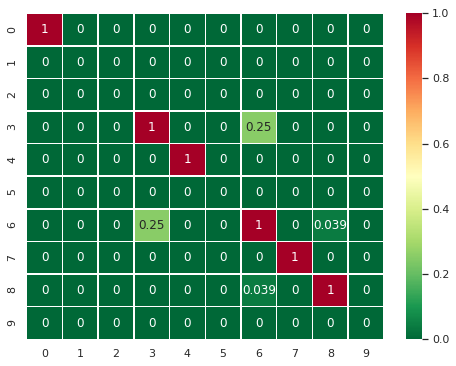

In [142]:
plt.figure(figsize = (8,6))
sns.heatmap(user_correlation[:10, :10], cmap='RdYlGn_r', linewidths=0.5, annot=True)

#### 4. Compute and visualise the similarity between the first 10 beers.

In [143]:
mean = np.nanmean(df_item_model, axis=1)
df_subtracted = (df_item_model.T-mean).T

In [144]:
df_subtracted.head()

review_profilename,0110x011,01Ryan10,04101Brewer,05Harley,0beerguy0,0runkp0s,0tt0,1000Bottles,100floods,1050Sudz,108Dragons,1099,1121987,11millsown113,11osixBrew,11thFloorBrewing,12ouncecurls,12vUnion,13aphomet,13smurrf,160Shillings,1759Girl,18alpha,1Adam12,1after909,1fastz28,1inamill,1morebeer,1noa,1quiks10,1santore,1whiskey,20ozmonkey,21mmer,220emaple,2378GCGTG,23fyerfyter,24Beer92,28Rock,2BDChicago,...,zfjohnson,zhanson88,zhooker,zic,ziggy13,zimm421,zimmerbloke,zipperergj,zjungleist,zloew,zminor,zms101,znarf,znichols,zodiacv1,zodiak3000,zooalbert,zooga,zook74,zoolzoo,zornbeast,zoso1967,zoso493,zplug123,zrab11,zseeanz,zsk,ztaylor1,ztprez,zuccard,zuffenhausen,zuggy9,zulufactor,zwalk8,zymrgy,zymurgy4all,zymurgywhiz,zythus,zyzygy,zzajjber
beer_beerid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.29096,-0.209040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.778986,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.112179,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[ 1.00000000e+00  8.29686245e-03  2.31720924e-03 ...  7.95984223e-05
   1.41341239e-02 -3.28010645e-03]
 [ 8.29686245e-03  1.00000000e+00  1.74066299e-03 ... -1.34282657e-02
   2.26833774e-03  4.21673842e-03]
 [ 2.31720924e-03  1.74066299e-03  1.00000000e+00 ...  0.00000000e+00
   8.66663720e-04  2.16803081e-02]
 ...
 [ 7.95984223e-05 -1.34282657e-02  0.00000000e+00 ...  1.00000000e+00
   9.49920731e-03  2.53744976e-02]
 [ 1.41341239e-02  2.26833774e-03  8.66663720e-04 ...  9.49920731e-03
   1.00000000e+00 -1.74653081e-02]
 [-3.28010645e-03  4.21673842e-03  2.16803081e-02 ...  2.53744976e-02
  -1.74653081e-02  1.00000000e+00]]


In [146]:
item_correlation[item_correlation<0]=0
item_correlation

array([[1.00000000e+00, 8.29686245e-03, 2.31720924e-03, ...,
        7.95984223e-05, 1.41341239e-02, 0.00000000e+00],
       [8.29686245e-03, 1.00000000e+00, 1.74066299e-03, ...,
        0.00000000e+00, 2.26833774e-03, 4.21673842e-03],
       [2.31720924e-03, 1.74066299e-03, 1.00000000e+00, ...,
        0.00000000e+00, 8.66663720e-04, 2.16803081e-02],
       ...,
       [7.95984223e-05, 0.00000000e+00, 0.00000000e+00, ...,
        1.00000000e+00, 9.49920731e-03, 2.53744976e-02],
       [1.41341239e-02, 2.26833774e-03, 8.66663720e-04, ...,
        9.49920731e-03, 1.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 4.21673842e-03, 2.16803081e-02, ...,
        2.53744976e-02, 0.00000000e+00, 1.00000000e+00]])

In [147]:
item_predicted_ratings = np.dot((df_item_model.fillna(0).T), item_correlation)
item_predicted_ratings

array([[0.0994061 , 0.87828887, 0.90919557, ..., 0.61956095, 0.73947902,
        0.84775993],
       [0.        , 0.        , 0.04009755, ..., 0.17084681, 0.08474766,
        0.        ],
       [0.        , 0.05553946, 0.02182215, ..., 0.        , 0.        ,
        0.10862397],
       ...,
       [0.15924966, 0.        , 0.09191914, ..., 0.04902684, 0.13055952,
        0.07705083],
       [0.00274526, 0.18399622, 0.05598312, ..., 0.        , 0.02388247,
        0.09404912],
       [0.        , 0.02822365, 0.03963099, ..., 0.        , 0.        ,
        0.        ]])

In [148]:
item_predicted_ratings.shape

(17202, 2028)

In [149]:
dummy_train.shape

(17202, 2028)

In [150]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

beer_beerid,5,6,7,10,14,15,17,19,30,31,33,34,36,39,54,55,58,59,61,63,65,67,69,73,74,78,79,80,81,82,83,85,86,87,88,89,90,92,93,96,...,65200,65325,65862,66036,66037,66281,66436,67040,67044,67106,67156,67219,67230,67262,67267,68008,68400,68746,68772,68916,68958,68960,69070,69363,69407,70102,70910,71405,71758,71774,71919,71969,72138,73131,74123,74272,74323,74390,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0110x011,0.099406,0.878289,0.909196,0.593557,0.803908,0.460722,0.428624,0.204372,0.995046,0.774910,0.636437,0.668239,0.616128,0.764181,0.665554,0.171855,0.859274,0.643383,0.730736,0.650251,0.232937,0.641869,0.251585,0.743249,0.471632,0.517054,0.213450,0.869862,0.757764,0.083632,0.352779,0.628622,0.149574,0.879295,0.475857,0.408668,0.640658,0.615725,0.209488,0.461749,...,0.538712,0.427655,1.686518,0.625900,0.675716,0.623906,0.748550,1.034758,1.118091,0.551433,0.359090,1.502744,1.202561,0.562376,0.575166,0.314059,0.533620,0.236746,0.623100,0.286837,2.291493,1.160481,0.716305,0.903588,0.112032,1.647470,1.012035,0.802181,0.149042,0.219982,0.849710,0.470616,0.890109,0.609071,0.218864,0.409848,0.107322,0.619561,0.739479,0.847760
01Ryan10,0.000000,0.000000,0.040098,0.000000,0.000000,0.000000,0.064517,0.000000,0.024697,0.000000,0.000000,0.000000,0.095458,0.081640,0.035613,0.097751,0.000000,0.205976,0.020531,0.030121,0.076552,0.000000,0.053438,0.000000,0.038903,0.000000,0.072837,0.000000,0.000000,0.000000,0.000000,0.072175,0.006872,0.000000,0.021009,0.000000,0.000000,0.000000,0.017955,0.000000,...,0.117627,0.105754,0.845878,0.013606,0.000000,0.000000,0.084510,0.012288,0.000000,0.067103,0.000000,0.335937,0.000000,0.000000,0.000000,0.036076,0.000000,0.315511,0.118215,0.227713,0.039270,0.051938,0.000000,0.193317,0.327438,0.058835,0.000000,0.157602,0.000000,0.197080,0.374977,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.170847,0.084748,0.000000
04101Brewer,0.000000,0.055539,0.021822,0.039627,0.000000,0.000000,0.000000,0.000000,0.071548,0.183827,0.000000,0.002396,0.021163,0.000000,0.000000,0.000000,0.000000,0.049459,0.028159,0.027135,0.000000,0.000000,0.000000,0.006687,0.142565,0.000000,0.005643,0.018533,0.330980,0.000000,0.000000,0.119001,0.002747,0.025836,0.007201,0.000000,0.046494,0.005116,0.000000,0.052667,...,0.013844,0.000000,0.000000,0.000000,0.000000,0.000000,0.038105,0.000000,0.000000,0.031524,0.270935,0.065512,0.000000,0.000000,0.295282,0.000000,0.080870,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.067154,0.008369,0.040401,0.026566,0.145270,0.039489,0.000000,0.000000,0.103284,0.019016,0.000000,0.000000,0.000000,0.000000,0.000000,0.108624
05Harley,0.902619,0.842791,0.851105,0.847210,0.332496,0.242188,0.565839,0.470758,0.862658,0.668880,0.600736,0.702118,0.788827,0.516373,0.817227,0.541979,0.414627,0.868598,0.383972,0.583137,0.349832,0.792348,0.234120,0.720485,0.596206,0.410911,0.719017,0.676635,0.853451,0.182723,0.629012,0.943854,0.330804,0.515629,0.765553,0.450257,0.950385,0.817992,0.360227,0.491879,...,0.803142,0.265316,1.011213,1.342085,0.340517,0.919311,1.140706,0.566073,0.897137,0.340922,0.326395,0.420468,0.709256,0.537462,0.661122,0.842102,0.692923,0.287065,0.468493,0.395272,0.491073,0.944684,0.641489,0.719414,0.679565,1.976326,0.737062,0.710694,0.296589,0.488828,0.584657,0.807530,0.889584,0.995129,0.112249,0.858225,0.527618,0.315805,0.915341,0.546106
0beerguy0,0.058605,0.292626,0.119413,0.318746,0.121850,0.282048,0.127374,0.030503,0.031454,0.133798,0.080549,0.076039,0.173828,0.124916,0.083694,0.108054,0.249909,0.255637,0.062112,0.346773,0.091902,0.217645,0.071121,0.051584,0.207827,0.097331,0.215266,0.273641,0.564552,0.046951,0.079012,0.490793,0.186044,0.096922,0.177190,0.224550,0.081339,0.003598,0.160475,0.005164,...,0.014143,0.000000,0.029556,0.037486,0.000000,0.005998,0.029363,0.209009,0.100566,0.010806,0.065054,0.012784,0.062162,0.015026,0.194929,0.053084,0.023846,0.000000,0.053264,0.007928,0.000000,0.296558,0.222401,0.036733,0.

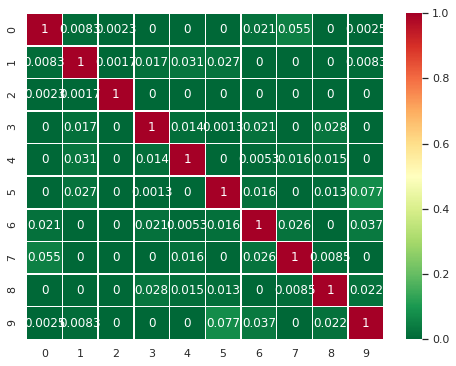

In [151]:
plt.figure(figsize = (8,6))
sns.heatmap(item_correlation[:10, :10], cmap='RdYlGn_r', linewidths=0.5, annot=True)

#### 3.5. Compare the performance of the two models using test data and suggest the one that should be deployed.

In [152]:
# Create pivot using test data
test_ = test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

#### Calculate RMSE value for user based model

In [153]:
# User based
df_test_user = test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
)

mean = np.nanmean(df_test_user, axis=1)
test_df_subtracted = (df_test_user.T-mean).T

test_user_correlation = 1 - pairwise_distances(test_df_subtracted.fillna(0), metric='cosine')
test_user_correlation[np.isnan(test_user_correlation)] = 0
print(test_user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [154]:
# User based
test_user_correlation[test_user_correlation<0]=0
test_user_predicted_ratings = np.dot(test_user_correlation, df_test_user.fillna(0))
test_user_predicted_ratings

array([[0.25759248, 1.03114226, 0.42726579, ..., 0.16461519, 0.60528718,
        0.74483352],
       [0.17607375, 0.59829136, 0.41797999, ..., 0.71338242, 0.        ,
        0.26969114],
       [0.35672692, 0.63287196, 0.06750944, ..., 0.6041211 , 0.        ,
        0.07923394],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.53947716, 1.81844717, 0.45549682, ..., 0.00343226, 0.73337831,
        1.22483534],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [155]:
# User based
test_user_final_rating = np.multiply(test_user_predicted_ratings, dummy_test)
test_user_final_rating.head(15)

beer_beerid,5,6,7,10,14,15,17,19,30,31,33,34,36,39,54,55,58,59,61,63,65,67,69,73,74,78,79,80,81,82,83,85,86,87,88,89,90,92,93,96,...,65200,65325,65862,66036,66037,66281,66436,67040,67044,67106,67156,67219,67230,67262,67267,68008,68400,68746,68772,68916,68958,68960,69070,69363,69407,70102,70910,71405,71758,71774,71919,71969,72138,73131,74123,74272,74323,74390,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05Harley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0tt0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100floods,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.902635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1099,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1121987,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11millsown113,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
11osixBrew,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [156]:
# User based
X  = test_user_final_rating.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(copy=True, feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [157]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

# User based model RMSE value
rmse = (sum(sum((test_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.006925814879842


For user based model RMSE value comes out to be **2.006925814879842**

#### Calculate RMSE value for item based model

In [158]:
# Item based
df_test_item = test.pivot(
    index='review_profilename',
    columns='beer_beerid',
    values='review_overall'
).T

mean = np.nanmean(df_test_item, axis=1)
test_df_subtracted = (df_test_item.T-mean).T

test_item_correlation = 1 - pairwise_distances(test_df_subtracted.fillna(0), metric='cosine')
test_item_correlation[np.isnan(test_item_correlation)] = 0
print(test_user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [159]:
# Item based
test_item_correlation[test_item_correlation<0]=0
test_item_predicted_ratings = (np.dot(test_item_correlation, df_test_item.fillna(0))).T
test_item_predicted_ratings

array([[0.18669938, 0.28140581, 0.04334618, ..., 0.        , 0.05580974,
        0.22449523],
       [0.21585441, 0.05554333, 0.05227115, ..., 0.17733434, 0.0225465 ,
        0.11097789],
       [0.11221003, 0.04447646, 0.02096145, ..., 0.00880171, 0.        ,
        0.03275811],
       ...,
       [0.09821466, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.14222571, 0.07238798, 0.13880986, ..., 0.02033064, 0.07829532,
        0.0679591 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [160]:
# Item based
test_item_final_rating = np.multiply(test_item_predicted_ratings, dummy_test)
test_item_final_rating.head()

beer_beerid,5,6,7,10,14,15,17,19,30,31,33,34,36,39,54,55,58,59,61,63,65,67,69,73,74,78,79,80,81,82,83,85,86,87,88,89,90,92,93,96,...,65200,65325,65862,66036,66037,66281,66436,67040,67044,67106,67156,67219,67230,67262,67267,68008,68400,68746,68772,68916,68958,68960,69070,69363,69407,70102,70910,71405,71758,71774,71919,71969,72138,73131,74123,74272,74323,74390,74986,75086
review_profilename,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0110x011,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
05Harley,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0tt0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1001111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100floods,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.904903,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [161]:
# Item based
X  = test_item_final_rating.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(copy=True, feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


In [162]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

rmse = (sum(sum((test_ - y )**2))/total_non_nan)**0.5
print(rmse)

1.9325670830061024


For user based model RMSE value comes out to be **1.9325670830061024**

Since the RMSE value of item based model is less than the user based model, so the item based model should be deployed.

#### 3.6. Give the names of the top 5 beers that you would recommend to the users 'cokes', 'genog' and 'giblet' using both the models.

##### Top 5 beers based on user based model.

In [163]:
user_final_rating.loc['cokes'].sort_values(ascending=False)[0:5]

beer_beerid
412     42.048229
1093    38.781419
1708    36.911971
4083    36.850615
34      36.494164
Name: cokes, dtype: float64

In [164]:
user_final_rating.loc['genog'].sort_values(ascending=False)[0:5]

beer_beerid
2093    33.613647
1093    32.375077
1013    29.789423
34      29.485823
92      29.386374
Name: genog, dtype: float64

In [165]:
user_final_rating.loc['giblet'].sort_values(ascending=False)[0:5]

beer_beerid
2093    63.411020
104     62.002390
412     61.935268
1093    56.511968
34      53.872070
Name: giblet, dtype: float64

##### Top 5 beers based on item based model.

In [166]:
item_final_rating.loc['cokes'].sort_values(ascending=False)[0:5]

beer_beerid
36179    12.054260
28268    11.488170
24905    11.420307
2219     10.555685
28267    10.515109
Name: cokes, dtype: float64

In [167]:
item_final_rating.loc['genog'].sort_values(ascending=False)[0:5]

beer_beerid
2508    4.048396
408     3.763220
356     3.730033
7799    3.685414
646     3.651358
Name: genog, dtype: float64

In [168]:
item_final_rating.loc['giblet'].sort_values(ascending=False)[0:5]

beer_beerid
259     4.037665
1015    3.918037
9182    3.867526
729     3.732890
782     3.609797
Name: giblet, dtype: float64